In [3]:
import numpy as np
import matplotlib.pyplot as plt

We consider a case where some number of chickens and ducks are within the same flock, and additionally, some chickens will be under surveillance.

In [129]:
# set number of species and flocks
num_flocks = 1 + 1 # +1 chicken surveillence - technically still one flock, add one to make tracking easier. Need to reflect in beta, sigma, and gamma 
num_species = 2 # chicken and duck - chicken is species 0, duck is species 1.


In [130]:
# set initial conditions 

# the following convention will be used: first dimension will represent which flock, second is which species, third is the compartment.
init_val = np.zeros((num_flocks, num_species, 6)) # Six possible compartment: S, E_S, E_A, I_S, I_A, R

# first let all birds to start susceptible, also choose population size here.
init_val[0,0,0] += 3000 # <---- set total chicken population
init_val[0,1,0] += 300 # <---- set total duck population

surveillance = 30 # <---- choose how many chickens to be under surveillance

init_val[0,0,0] -= surveillance
init_val[1,0,0] += surveillance # chicken under surveillance moved to 'flock' 1


# store the total population for each flock and each species
tot_popul = init_val[:,:,0].copy()

# then choose a bird to be exposed (symptomatic), here we assume it to be the duck
init_val[0,1,0] -= 1
init_val[0,1,1] += 1


In [131]:
# this is the maximum number of events that would occur, typically the number will not be reached, but 
# for diseases that does not die out this is necessary to not fall into an infinite while loop.
max_events = 500000


We consider each of the parameter: firstly the infection rate (from symptomatic birds). The $(a,b,c,d)$-th entry of the 4-rank tensor `beta_S` means "the infection rate from a symptomatic infectious bird in flock $a$ species $b$, to flock $c$ species $d$".

In [132]:
# initialise the infection rate tensor
beta_S = np.zeros((num_flocks, num_species, num_flocks, num_species))

beta_S[:, 0, :, 0] = 0.47 # within-chicken infection
beta_S[:, 1, :, 0] = 0.3 # chicken-to-duck infection
beta_S[:, 1, :, 0] = 1.5 # duck-to-chicken infection
beta_S[:, 1, :, 1] = 1.5 # within-duck infection


Same idea applies to asymptomatic birds.

In [133]:
# initialise the infection rate tensor
beta_A = np.zeros((num_flocks, num_species, num_flocks, num_species))

beta_A[:, 0, :, 0] = 0.01 # within-chicken infection
beta_A[:, 1, :, 0] = 0.01 # chicken-to-duck infection
beta_A[:, 1, :, 0] = 1 # duck-to-chicken infection
beta_A[:, 1, :, 1] = 1 # within-duck infection

Now consider the latency and infectious period, probability of symptom display.

In [134]:
# latency and infectious period, can be changed
latency_period_S = 1 * np.ones(num_species)
sigma_S = np.ones(num_species) / latency_period_S
latency_period_A = 0.5 * np.ones(num_species)
sigma_A = np.ones(num_species) / latency_period_A

infectious_period_S = 3.2 * np.ones(num_species)
gamma_S = np.ones(num_species) / infectious_period_S
infectious_period_A = 1.9 * np.ones(num_species)
gamma_A = np.ones(num_species) / infectious_period_A

# probability of displaying symptoms, can be changed
p_S = np.array([0.85, 0.01])
p_A = np.ones(num_species) - p_S

We have the following update rules for a bird in flock $a$ and of species $b$ (for sympotomatic case only, asymptomatic case follows similar reasoning):
$$ \begin{align*}
S_{(a,b)} &\xrightarrow{ p_{Sb} \sum_{(i,j)} \frac{1}{N_{i,j}} (\beta_{S(i,j,a,b)} I_{S(i,j)} + \beta_{A(i,j,a,b)} I_{A(i,j)})}E_{S(a,b)} \\
E_{S(a,b)} &\xrightarrow{\sigma_{Sb}} I_{S(a,b)} \\
I_{S(a,b)} &\xrightarrow{\gamma_{Sb}} R_{(a,b)}
\end{align*}
$$

We define each of the rules into a function.

In [135]:
def S_to_E(a, b, current_val, symptomatic = True, tot_popul=tot_popul, beta_S=beta_S, beta_A=beta_A, p_S=p_S, p_A=p_A, num_flocks=num_flocks, num_species=num_species):
    val = 0
    for i in range(num_flocks):
        for j in range(num_species):
            if tot_popul[i,j] != 0:
                val += (beta_S[i,j,a,b] * current_val[i,j,3] + beta_A[i,j,a,b] * current_val[i,j,4]) / tot_popul[i,j]
    if symptomatic:
        val = val * current_val[a,b,0] * p_S[b]
    else:
        val = val * current_val[a,b,0] * p_A[b]
    return val

def E_to_I(a, b, current_val, symptomatic = True, tot_popul=tot_popul, sigma_S=sigma_S, sigma_A=sigma_A, num_flocks=num_flocks, num_species=num_species):
    if symptomatic:
        return current_val[a,b,1] * sigma_S[b]
    else:
        return current_val[a,b,2] * sigma_A[b]

def I_to_R(a, b, current_val, symptomatic = True, tot_popul=tot_popul, gamma_S=gamma_S, gamma_A=gamma_A, num_flocks=num_flocks, num_species=num_species):
    if symptomatic:
        return current_val[a,b,3] * gamma_S[b]
    else:
        return current_val[a,b,4] * gamma_A[b]
    

In [136]:
def Gillespie_simu(max_events=max_events, init_val=init_val, tot_popul=tot_popul, 
                   beta_S=beta_S, beta_A=beta_A, sigma_S=sigma_S, sigma_A=sigma_A,
                    gamma_S=gamma_S, gamma_A=gamma_A, p_S=p_S, p_A=p_A, num_flocks=num_flocks, 
                    num_species=num_species):

    # initialise the event count and current values

    num_event = 0
    current_val = init_val.copy()

    # set the time and state sequence
    t = [0] + [None] * max_events
    y = [init_val] + [None] * max_events


    while (num_event < max_events) and (np.sum(current_val[:,:,1:5]) > 0): # stop the loop if: 1. maximum event number is reached, or 2. no more infections can possibly occur.
        
        num_event += 1

        ##### create an event tensor ####

        all_events = np.zeros((num_flocks, num_species, 6)) # six types of update rules in total

        for a in range(num_flocks):
            for b in range(num_species):
                all_events[a,b,0] = S_to_E(a, b, current_val, True)
                all_events[a,b,1] = S_to_E(a, b, current_val, False)
                all_events[a,b,2] = E_to_I(a, b, current_val, True)
                all_events[a,b,3] = E_to_I(a, b, current_val, False)
                all_events[a,b,4] = I_to_R(a, b, current_val, True)
                all_events[a,b,5] = I_to_R(a, b, current_val, False)

        # store total rate to rescale later
        tot_rate = np.sum(all_events)
        
        # do a time leap
        
        r1 = np.random.uniform()
        t[num_event] = t[num_event-1] - np.log(r1) / tot_rate
        
        # then choose events, first choose the type of events (S to E_S, S to E_A, E_S to I_S, E_A to I_A, I_S to R, or I_A to R)
        
        r2 = np.random.uniform()

        for event in range(6):
            if r2 < np.sum(all_events[:,:,0:event+1]) / tot_rate:
                type_event = event
                break

        # then choose which flock gets updated
        
        r3 = np.random.uniform()
        spec_event_rate = np.sum(all_events[:,:,type_event]) # total rate of a specific event occurring

        for i in range(num_flocks):
            if r3 < np.sum(all_events[0:i+1,:,type_event]) / spec_event_rate:
                flock_to_update = i
                break

        # finally choose which species get updated

        r4 = np.random.uniform()
        spec_event_flock_rate = np.sum(all_events[flock_to_update,:,type_event])

        for j in range(num_species):
            if r4 < np.sum(all_events[flock_to_update,0:j+1,type_event]) / spec_event_flock_rate:
                species_to_update = j
                break

        # do the updating
        if type_event == 0:
            current_val[flock_to_update, species_to_update, 0] -= 1
            current_val[flock_to_update, species_to_update, 1] += 1
        if type_event == 1:
            current_val[flock_to_update, species_to_update, 0] -= 1
            current_val[flock_to_update, species_to_update, 2] += 1
        if type_event == 2:
            current_val[flock_to_update, species_to_update, 1] -= 1
            current_val[flock_to_update, species_to_update, 3] += 1
        if type_event == 3:
            current_val[flock_to_update, species_to_update, 2] -= 1
            current_val[flock_to_update, species_to_update, 4] += 1
        if type_event == 4:
            current_val[flock_to_update, species_to_update, 3] -= 1
            current_val[flock_to_update, species_to_update, 5] += 1
        if type_event == 5:
            current_val[flock_to_update, species_to_update, 4] -= 1
            current_val[flock_to_update, species_to_update, 5] += 1

        # store the updated value

        y[num_event] = current_val.copy()

    # get rid of none value if there is any:
    t = np.array(t[0:num_event+1])
    y = np.array(y[0:num_event+1])

    return t, y
        

We can define a few functions that allows us to collect some key statistics and plot some graphs.

In [137]:
# function that allows aggregated data depending on specified flock or species.

def aggregate(y, flock_lst: list, species_lst: list):
    y = y[:, flock_lst][:, :, species_lst,:]
    return np.sum(y, axis=(1,2))

# function to do plotting: choose which flocks and species to consider, add the total up, 
# choose which compartment to show

def dynamics_plot_aggregate(t, y, flock_lst: list, species_lst: list, title,
                            susceptible=True, exposed_symptomatic=True,
                            exposed_asymptomatic=True, infectious_symptomatic=True,
                            infectious_asymptomatic=True, removed=True):
    y_aggregated = aggregate(y, flock_lst, species_lst)
    if susceptible:
        plt.plot(t, y_aggregated[:, 0], label='susceptible')
    if exposed_symptomatic:
        plt.plot(t, y_aggregated[:, 1], label='exposed symtomatic')
    if exposed_asymptomatic:
        plt.plot(t, y_aggregated[:, 2], label='exposed asymtomatic')
    if infectious_symptomatic:
        plt.plot(t, y_aggregated[:, 3], label='infectious symtomatic')
    if infectious_asymptomatic:
        plt.plot(t, y_aggregated[:, 4], label='infectious asymtomatic')
    if removed:
        plt.plot(t, y_aggregated[:, 5], label='removed')
    plt.legend()
    plt.xlabel('time (days)')
    plt.ylabel('bird population')
    plt.title(title)

    plt.show()


We now do some example plots, firstly the dynamics of all chickens:

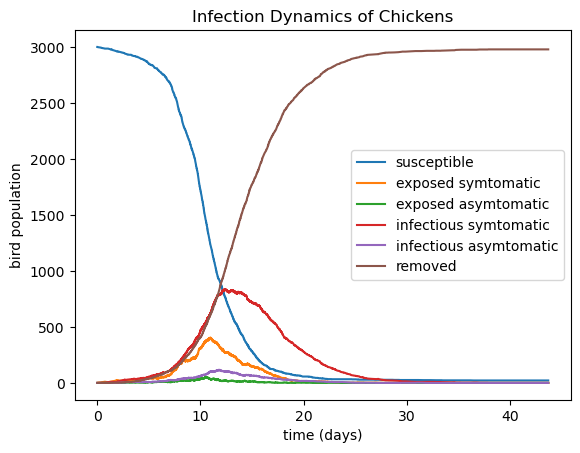

In [138]:
t,y = Gillespie_simu()
dynamics_plot_aggregate(t, y, [0,1], [0], 'Infection Dynamics of Chickens')

And ducks:

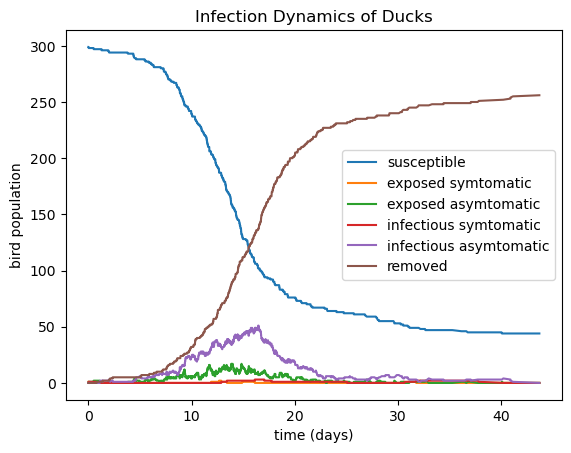

In [139]:
dynamics_plot_aggregate(t, y, [0,1], [1], 'Infection Dynamics of Ducks')

Number of infectious (symptomatic) chickens that could be detected due to surveillance.

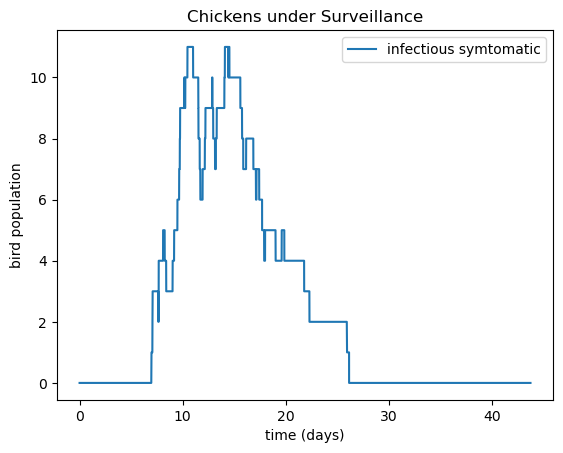

In [140]:
dynamics_plot_aggregate(t, y, [1], [0], 'Chickens under Surveillance', susceptible=False,
                        exposed_symptomatic=False, exposed_asymptomatic=False,
                        infectious_symptomatic=True,
                        infectious_asymptomatic=False, removed=False)

Record key statistics:

- Whether an outbreak has occurred (Infectious population >= 5 at any point, both the population as a whole and individual species).
- Time of outbreak occurrence if there is an outbreak.
- The peak size of the epidemic, and when it occurred (both the population as a whole and individual flocks).
- The final size of the epidemic, and when it finished.


In [141]:
######## Outbreak statistics ########
def outbreak_statistics(t, y, outbreak_threshold = 5):
    # Outbreak or not
    outbreak = len([state for state in y if np.sum(state[:,:,3:5]) >= outbreak_threshold]) > 0

    # if there is an outbreak, when does it happen
    if outbreak:
        outbreak_time = t[[i for i, state in enumerate(y) if np.sum(state[:,:,3:5]) >= outbreak_threshold][0]]
    else:
        outbreak_time = None

    # Species-specific outbreak
    outbreak_indiv = [len([state for state in y if np.sum(state[:,i,3:5]) >= outbreak_threshold]) > 0 for i in range(num_species)]
    outbreak_time_indiv = [t[[j for j, state in enumerate(y) if np.sum(state[:,i,3:5]) >= outbreak_threshold][0]] if outbreak_indiv[i] else None for i in range(num_species)]
    return outbreak, outbreak_time, outbreak_indiv, outbreak_time_indiv


In [142]:
def peak_size(t, y):
    ######## Peak size for all flocks as a whole ########
    peak_size_whole = np.max([np.sum(state[:,:,3:5]) for state in y])
    peak_time_whole = t[np.argmax([np.sum(state[:,:,3:5]) for state in y])]

    ######## Individual species peak size ########
    peak_size_indiv = [np.amax([np.sum(state[:,i,3:5]) for state in y], axis=0) for i in range(num_species)]
    peak_time_indiv = [t[j] for j in [np.argmax([np.sum(state[:,i,3:5]) for state in y], axis=0) for i in range(num_species)]]
    return peak_size_whole, peak_time_whole, peak_size_indiv, peak_time_indiv

In [143]:
def final_size_end_time(t, y):
    ######## Final size ########
    final_size = np.sum(y[-1,:,:,-1], axis=1)
    end_time = t[-1]
    return final_size, end_time

Suppose that for every certain number of days, a testing on the chicken under surveillance is done. We would like to ask:
- What is the overall dynamics of chicken at the point of a detection?
- If no positive case is detected, could it be a failed detection instead?

We attempt to answer the questions via the following:

In [144]:
testing_period = 7 # <---- set the period of testing

testing_time = np.array(range(0, int(max(t)), testing_period))
testing_index = np.zeros(len(testing_time))

for test in range(len(testing_time)):
    i = np.searchsorted(t, testing_time[test], side='right') - 1
    testing_index[test] = i
    
# Obtain the result of all testing:
testing_result = [y[int(i), 1, 0, 3] for i in testing_index]
y_during_testing = [y[int(i), :, :, :] for i in testing_index]

for test in range(len(testing_time)):
    print(f'During test {test}:')
    print(f'{int(testing_result[test])} sentinel chickens has been detected')
    print(f'{int(np.sum(y[int(testing_index[test]), :, 0, 3]))} actual infectious (symptomatic) chickens are present')



During test 0:
0 sentinel chickens has been detected
0 actual infectious (symptomatic) chickens are present
During test 1:
1 sentinel chickens has been detected
110 actual infectious (symptomatic) chickens are present
During test 2:
9 sentinel chickens has been detected
799 actual infectious (symptomatic) chickens are present
During test 3:
4 sentinel chickens has been detected
218 actual infectious (symptomatic) chickens are present
During test 4:
0 sentinel chickens has been detected
23 actual infectious (symptomatic) chickens are present
During test 5:
0 sentinel chickens has been detected
3 actual infectious (symptomatic) chickens are present
During test 6:
0 sentinel chickens has been detected
0 actual infectious (symptomatic) chickens are present


We do a number of simulations and collect key statistics.

In [145]:
def mass_simu(num_simu, max_events=max_events, init_val=init_val, tot_popul=tot_popul, 
                   beta_S=beta_S, beta_A=beta_A, sigma_S=sigma_S, sigma_A=sigma_A,
                    gamma_S=gamma_S, gamma_A=gamma_A, p_S=p_S, p_A=p_A, num_flocks=num_flocks, 
                    num_species=num_species):
    t_mass_simu = []
    y_mass_simu = []
    for iters in range(num_simu):
        t, y = Gillespie_simu(max_events, init_val, tot_popul, 
                              beta_S, beta_A, sigma_S, sigma_A, gamma_S, 
                              gamma_A, p_S, p_A, num_flocks, num_species)
        t_mass_simu.append(t)
        y_mass_simu.append(y)
    return t_mass_simu, y_mass_simu

def mass_outbreak_statistics(t_mass_simu, y_mass_simu, outbreak_threshold=5):
    mass_outbreak =[]
    mass_outbreak_time = []
    mass_outbreak_indiv = []
    mass_outbreak_time_indiv = []
    for i in range(len(t_mass_simu)):
        outbreak, outbreak_time, outbreak_indiv, outbreak_time_indiv = outbreak_statistics(t_mass_simu[i], y_mass_simu[i], outbreak_threshold)
        mass_outbreak.append(outbreak)
        mass_outbreak_time.append(outbreak_time)
        mass_outbreak_indiv.append(outbreak_indiv)
        mass_outbreak_time_indiv.append(outbreak_time_indiv)
    mass_outbreak = np.array(mass_outbreak)
    mass_outbreak_time = np.array(mass_outbreak_time)
    mass_outbreak_indiv = np.array(mass_outbreak_indiv)
    mass_outbreak_time_indiv = np.array(mass_outbreak_time_indiv)
    return mass_outbreak, mass_outbreak_time, mass_outbreak_indiv, mass_outbreak_time_indiv

def mass_peak_size(t_mass_simu, y_mass_simu):
    mass_peak_size_whole = []
    mass_peak_time_whole = []
    mass_peak_size_indiv = []
    mass_peak_time_indiv = []
    for i in range(len(t_mass_simu)):
        peak_size_whole, peak_time_whole, peak_size_indiv, peak_time_indiv = peak_size(t_mass_simu[i], y_mass_simu[i])
        mass_peak_size_whole.append(peak_size_whole)
        mass_peak_time_whole.append(peak_time_whole)
        mass_peak_size_indiv.append(peak_size_indiv)
        mass_peak_time_indiv.append(peak_time_indiv)
    mass_peak_size_whole = np.array(mass_peak_size_whole)
    mass_peak_time_whole = np.array(mass_peak_time_whole)
    mass_peak_size_indiv = np.array(mass_peak_size_indiv)
    mass_peak_time_indiv = np.array(mass_peak_time_indiv)
    return mass_peak_size_whole, mass_peak_time_whole, mass_peak_size_indiv, mass_peak_time_indiv

def mass_final_size_end_time(t_mass_simu, y_mass_simu):
    mass_final_size = []
    mass_end_time = []
    for i in range(len(t_mass_simu)):
        final_size, end_time = final_size_end_time(t_mass_simu[i], y_mass_simu[i])
        mass_final_size.append(final_size)
        mass_end_time.append(end_time)
    mass_final_size = np.array(mass_final_size)
    mass_end_time = np.array(mass_end_time)
    return mass_final_size, mass_end_time

In [146]:
num_simu = 100

t_mass_simu, y_mass_simu = mass_simu(num_simu)

In [147]:
mass_outbreak, mass_outbreak_time, mass_outbreak_indiv, mass_outbreak_time_indiv = mass_outbreak_statistics(t_mass_simu, y_mass_simu)
mass_peak_size_whole, mass_peak_time_whole, mass_peak_size_indiv, mass_peak_time_indiv = mass_peak_size(t_mass_simu, y_mass_simu)
mass_final_size, mass_end_time = mass_final_size_end_time(t_mass_simu, y_mass_simu)


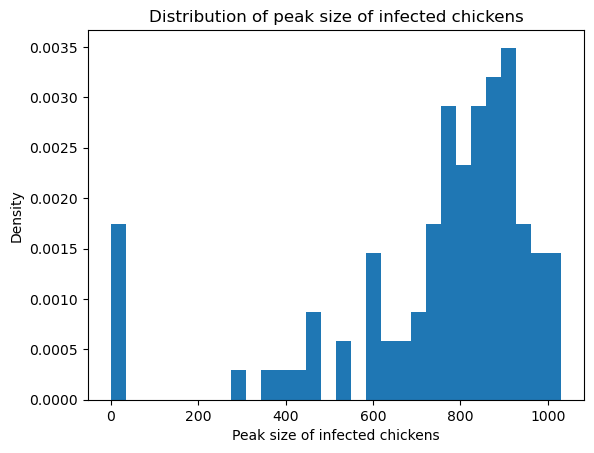

In [148]:
plt.hist(mass_peak_size_indiv[:,0],bins=30,density=True,label='chicken')
plt.xlabel('Peak size of infected chickens')
plt.ylabel('Density')
plt.title('Distribution of peak size of infected chickens')
plt.show()


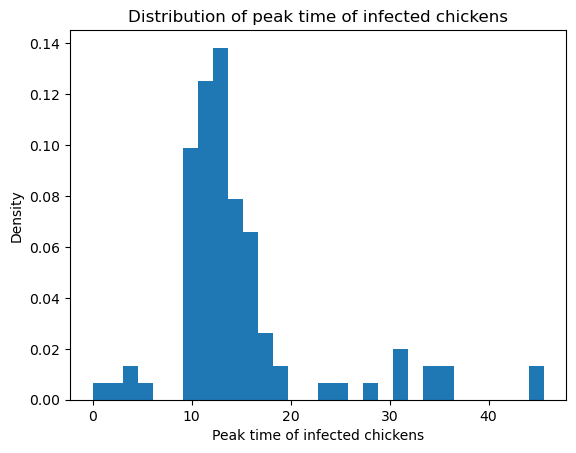

In [149]:
plt.hist(mass_peak_time_indiv[:,0],bins=30,density=True,label='chicken')
plt.xlabel('Peak time of infected chickens')
plt.ylabel('Density')
plt.title('Distribution of peak time of infected chickens')
plt.show()

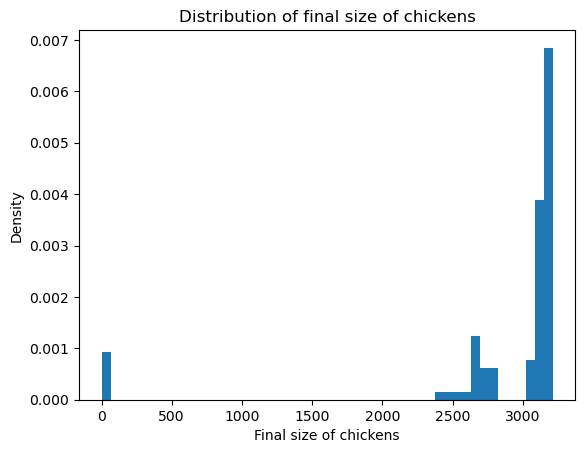

In [150]:
plt.hist(mass_final_size[:,0],density=True,bins=50,label='chicken')
plt.xlabel('Final size of chickens')
plt.ylabel('Density')
plt.title('Distribution of final size of chickens')
plt.show()

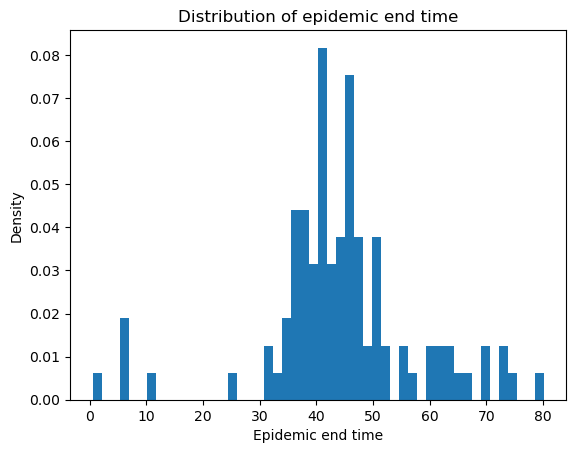

In [151]:
plt.hist(mass_end_time,density=True,bins=50)
plt.xlabel('Epidemic end time')
plt.ylabel('Density')
plt.title('Distribution of epidemic end time')
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

######## Changable Values ########
num_flocks = 1 + 1 # +1 chicken surveillence - technically still one flock, add one to make tracking easier. Need to reflect in beta, sigma, and gamma 
num_species = 2 # chicken and duck - chicken is species 0, duck is species 1.

num_simu = 500 # number of total simulations

tot_chicken_popul = 3000 # <---- set total chicken population
tot_duck_popul = 300 # <---- set total duck population
surveillance = 30 # <---- choose how many chickens to be under surveillance
testing_periods = [7, 14, 30] # <---- set the period of testing for surveillance

# initialise the infection rate tensor
beta_S = np.zeros((num_flocks, num_species, num_flocks, num_species))
beta_S[:, 0, :, 0] = 0.47 # within-chicken infection
beta_S[:, 1, :, 0] = 0.47 # chicken-to-duck infection
beta_S[:, 1, :, 0] = 1.5 # duck-to-chicken infection
beta_S[:, 1, :, 1] = 1.5 # within-duck infection

beta_A = np.zeros((num_flocks, num_species, num_flocks, num_species))
beta_A[:, 0, :, 0] = 0.01 # within-chicken infection
beta_A[:, 1, :, 0] = 0.01 # chicken-to-duck infection
beta_A[:, 1, :, 0] = 1 # duck-to-chicken infection
beta_A[:, 1, :, 1] = 1 # within-duck infection

# latency and infectious period
latency_period_S = 1 * np.ones(num_species)
sigma_S = np.ones(num_species) / latency_period_S
latency_period_A = 1 * np.ones(num_species)
sigma_A = np.ones(num_species) / latency_period_A

infectious_period_S = 3.2 * np.ones(num_species)
gamma_S = np.ones(num_species) / infectious_period_S
infectious_period_A = 1.9 * np.ones(num_species)
gamma_A = np.ones(num_species) / infectious_period_A

# probability of displaying symptoms
p_S = np.array([0.95, 0.01])
p_A = np.ones(num_species) - p_S


######## set initial conditions ######## 

# the following convention will be used: first dimension will represent which flock, second is which species, third is the compartment.
init_val = np.zeros((num_flocks, num_species, 6)) # Six possible compartment: S, E_S, E_A, I_S, I_A, R

# first let all birds to start susceptible, also choose population size here.
init_val[0,0,0] += tot_chicken_popul
init_val[0,1,0] += tot_duck_popul
init_val[0,0,0] -= surveillance
init_val[1,0,0] += surveillance # chicken under surveillance moved to 'flock 1'

# store the total population for each flock and each species
tot_popul = init_val[:,:,0].copy()

# then choose a bird to be exposed (symptomatic), here we assume it to be the duck
init_val[0,1,0] -= 1
init_val[0,1,1] += 1

# this is the maximum number of events that would occur, typically the number will not be reached, but 
# for diseases that does not die out this is necessary to not fall into an infinite while loop.
max_events = 500000

######## Define update rules to be used in the Gillespie Algorithm ########

def S_to_E(a, b, current_val, symptomatic = True, tot_popul=tot_popul, beta_S=beta_S, beta_A=beta_A, p_S=p_S, p_A=p_A, num_flocks=num_flocks, num_species=num_species):
    val = 0
    for i in range(num_flocks):
        for j in range(num_species):
            if tot_popul[i,j] != 0:
                val += (beta_S[i,j,a,b] * current_val[i,j,3] + beta_A[i,j,a,b] * current_val[i,j,4]) / tot_popul[i,j]
    if symptomatic:
        val = val * current_val[a,b,0] * p_S[b]
    else:
        val = val * current_val[a,b,0] * p_A[b]
    return val

def E_to_I(a, b, current_val, symptomatic = True, tot_popul=tot_popul, sigma_S=sigma_S, sigma_A=sigma_A, num_flocks=num_flocks, num_species=num_species):
    if symptomatic:
        return current_val[a,b,1] * sigma_S[b]
    else:
        return current_val[a,b,2] * sigma_A[b]

def I_to_R(a, b, current_val, symptomatic = True, tot_popul=tot_popul, gamma_S=gamma_S, gamma_A=gamma_A, num_flocks=num_flocks, num_species=num_species):
    if symptomatic:
        return current_val[a,b,3] * gamma_S[b]
    else:
        return current_val[a,b,4] * gamma_A[b]

######## Gillespie Algorithm ########

def Gillespie_simu(max_events=max_events, init_val=init_val, tot_popul=tot_popul, 
                   beta_S=beta_S, beta_A=beta_A, sigma_S=sigma_S, sigma_A=sigma_A,
                   gamma_S=gamma_S, gamma_A=gamma_A, p_S=p_S, p_A=p_A, num_flocks=num_flocks, 
                   num_species=num_species):

    # initialise the event count and current values

    num_event = 0
    current_val = init_val.copy()

    # set the time and state sequence
    t = [0] + [None] * max_events
    y = [init_val] + [None] * max_events


    while (num_event < max_events) and (np.sum(current_val[:,:,1:5]) > 0): # stop the loop if: 1. maximum event number is reached, or 2. no more infections can possibly occur.
        
        num_event += 1

        ##### create an event tensor ####

        all_events = np.zeros((num_flocks, num_species, 6)) # six types of update rules in total

        for a in range(num_flocks):
            for b in range(num_species):
                all_events[a,b,0] = S_to_E(a, b, current_val, True)
                all_events[a,b,1] = S_to_E(a, b, current_val, False)
                all_events[a,b,2] = E_to_I(a, b, current_val, True)
                all_events[a,b,3] = E_to_I(a, b, current_val, False)
                all_events[a,b,4] = I_to_R(a, b, current_val, True)
                all_events[a,b,5] = I_to_R(a, b, current_val, False)

        # store total rate to rescale later
        tot_rate = np.sum(all_events)
        
        # do a time leap
        
        r1 = np.random.uniform()
        t[num_event] = t[num_event-1] - np.log(r1) / tot_rate
        
        # then choose events, first choose the type of events (S to E_S, S to E_A, E_S to I_S, E_A to I_A, I_S to R, or I_A to R)
        
        r2 = np.random.uniform()

        for event in range(6):
            if r2 < np.sum(all_events[:,:,0:event+1]) / tot_rate:
                type_event = event
                break

        # then choose which flock gets updated
        
        r3 = np.random.uniform()
        spec_event_rate = np.sum(all_events[:,:,type_event]) # total rate of a specific event occurring

        for i in range(num_flocks):
            if r3 < np.sum(all_events[0:i+1,:,type_event]) / spec_event_rate:
                flock_to_update = i
                break

        # finally choose which species get updated

        r4 = np.random.uniform()
        spec_event_flock_rate = np.sum(all_events[flock_to_update,:,type_event])

        for j in range(num_species):
            if r4 < np.sum(all_events[flock_to_update,0:j+1,type_event]) / spec_event_flock_rate:
                species_to_update = j
                break

        # do the updating
        if type_event == 0:
            current_val[flock_to_update, species_to_update, 0] -= 1
            current_val[flock_to_update, species_to_update, 1] += 1
        if type_event == 1:
            current_val[flock_to_update, species_to_update, 0] -= 1
            current_val[flock_to_update, species_to_update, 2] += 1
        if type_event == 2:
            current_val[flock_to_update, species_to_update, 1] -= 1
            current_val[flock_to_update, species_to_update, 3] += 1
        if type_event == 3:
            current_val[flock_to_update, species_to_update, 2] -= 1
            current_val[flock_to_update, species_to_update, 4] += 1
        if type_event == 4:
            current_val[flock_to_update, species_to_update, 3] -= 1
            current_val[flock_to_update, species_to_update, 5] += 1
        if type_event == 5:
            current_val[flock_to_update, species_to_update, 4] -= 1
            current_val[flock_to_update, species_to_update, 5] += 1

        # store the updated value

        y[num_event] = current_val.copy()

    # get rid of none value if there is any:
    t = np.array(t[0:num_event+1])
    y = np.array(y[0:num_event+1])

    return t, y

######## Outbreak statistics ########
def outbreak_statistics(t, y, outbreak_threshold = 5):
    # Outbreak or not
    outbreak = len([state for state in y if np.sum(state[:,:,3:5]) >= outbreak_threshold]) > 0

    # if there is an outbreak, when does it happen
    if outbreak:
        outbreak_time = t[[i for i, state in enumerate(y) if np.sum(state[:,:,3:5]) >= outbreak_threshold][0]]
    else:
        outbreak_time = None

    # Species-specific outbreak
    outbreak_indiv = [len([state for state in y if np.sum(state[:,i,3:5]) >= outbreak_threshold]) > 0 for i in range(num_species)]
    outbreak_time_indiv = [t[[j for j, state in enumerate(y) if np.sum(state[:,i,3:5]) >= outbreak_threshold][0]] if outbreak_indiv[i] else None for i in range(num_species)]
    return outbreak, outbreak_time, outbreak_indiv, outbreak_time_indiv

######## Peak size statistics ########
def peak_size(t, y):
    ######## Peak size for all flocks as a whole ########
    peak_size_whole = np.max([np.sum(state[:,:,3:5]) for state in y])
    peak_time_whole = t[np.argmax([np.sum(state[:,:,3:5]) for state in y])]

    ######## Individual species peak size ########
    peak_size_indiv = [np.amax([np.sum(state[:,i,3:5]) for state in y], axis=0) for i in range(num_species)]
    peak_time_indiv = [t[j] for j in [np.argmax([np.sum(state[:,i,3:5]) for state in y], axis=0) for i in range(num_species)]]
    return peak_size_whole, peak_time_whole, peak_size_indiv, peak_time_indiv

######## Final size and end time ########
def final_size_end_time(t, y):
    ######## Final size ########
    final_size = np.sum(y[-1,:,:,-1], axis=1)
    end_time = t[-1]
    return final_size, end_time

######## Obtain time of surveillance outcomes ########

def surveillance_outcomes(t, y, testing_periods):
    detection_times = np.zeros(len(testing_periods))
    count = 0
    for testing_period in testing_periods:
        testing_time = np.array(range(0, int(max(t)), testing_period))
        testing_index = np.zeros(len(testing_time))

        for test in range(len(testing_time)):
            i = np.searchsorted(t, testing_time[test], side='right') - 1
            testing_index[test] = i

        # Obtain the result of all testing:
        testing_result = [y[int(i), 1, 0, 3] for i in testing_index] # test int(i), flock 1, chicken, I_S
        detection_time = next((testing_time[i] for i, x in enumerate(testing_result) if x > 3), None)

        detection_times[count] = detection_time
        count += 1

    return detection_times     


######## Collect all statistics for a number of simulations ########
def mass_simu(num_simu, max_events=max_events, init_val=init_val, tot_popul=tot_popul, 
                   beta_S=beta_S, beta_A=beta_A, sigma_S=sigma_S, sigma_A=sigma_A,
                    gamma_S=gamma_S, gamma_A=gamma_A, p_S=p_S, p_A=p_A, num_flocks=num_flocks, 
                    num_species=num_species):
    t_mass_simu = []
    y_mass_simu = []
    for iters in range(num_simu):
        t, y = Gillespie_simu(max_events, init_val, tot_popul, 
                              beta_S, beta_A, sigma_S, sigma_A, gamma_S, 
                              gamma_A, p_S, p_A, num_flocks, num_species)
        t_mass_simu.append(t)
        y_mass_simu.append(y)
    return t_mass_simu, y_mass_simu

def mass_outbreak_statistics(t_mass_simu, y_mass_simu, outbreak_threshold=5):
    n = len(t_mass_simu)
    mass_outbreak = np.zeros(n, dtype=bool)
    mass_outbreak_time = np.zeros(n)
    mass_outbreak_indiv = np.zeros((n, num_species), dtype=bool)
    mass_outbreak_time_indiv = np.zeros((n, num_species))
    for i in range(n):
        outbreak, outbreak_time, outbreak_indiv, outbreak_time_indiv = outbreak_statistics(t_mass_simu[i], y_mass_simu[i], outbreak_threshold)
        mass_outbreak[i] = outbreak
        mass_outbreak_time[i] = outbreak_time
        mass_outbreak_indiv[i] = outbreak_indiv
        mass_outbreak_time_indiv[i] = outbreak_time_indiv
    return mass_outbreak, mass_outbreak_time, mass_outbreak_indiv, mass_outbreak_time_indiv

def mass_peak_size(t_mass_simu, y_mass_simu):
    n = len(t_mass_simu)
    mass_peak_size_whole = np.zeros(n)
    mass_peak_time_whole = np.zeros(n)
    mass_peak_size_indiv = np.zeros((n, num_species))
    mass_peak_time_indiv = np.zeros((n, num_species))
    for i in range(n):
        peak_size_whole, peak_time_whole, peak_size_indiv, peak_time_indiv = peak_size(t_mass_simu[i], y_mass_simu[i])
        mass_peak_size_whole[i] = peak_size_whole
        mass_peak_time_whole[i] = peak_time_whole
        mass_peak_size_indiv[i] = peak_size_indiv
        mass_peak_time_indiv[i] = peak_time_indiv
    return mass_peak_size_whole, mass_peak_time_whole, mass_peak_size_indiv, mass_peak_time_indiv

def mass_final_size_end_time(t_mass_simu, y_mass_simu):
    n = len(t_mass_simu)
    mass_final_size = np.zeros((n, num_species))
    mass_end_time = np.zeros(n)
    for i in range(n):
        final_size, end_time = final_size_end_time(t_mass_simu[i], y_mass_simu[i])
        mass_final_size[i] = final_size
        mass_end_time[i] = end_time
    return mass_final_size, mass_end_time

######## Run the simulation ########
t_mass_simu, y_mass_simu = mass_simu(num_simu)

mass_outbreak, mass_outbreak_time, mass_outbreak_indiv, mass_outbreak_time_indiv = mass_outbreak_statistics(t_mass_simu, y_mass_simu)
mass_peak_size_whole, mass_peak_time_whole, mass_peak_size_indiv, mass_peak_time_indiv = mass_peak_size(t_mass_simu, y_mass_simu)
mass_final_size, mass_end_time = mass_final_size_end_time(t_mass_simu, y_mass_simu)

######## Create a csv file to store the results ########
df = pd.DataFrame({'Outbreak': mass_outbreak,
                    'Outbreak Time': mass_outbreak_time,
                    'Outbreak Chicken': mass_outbreak_indiv[:,0],
                    'Outbreak Duck': mass_outbreak_indiv[:,1], 
                    'Outbreak Time Chicken': mass_outbreak_time_indiv[:,0], 
                    'Outbreak Time Duck': mass_outbreak_time_indiv[:,1], 
                    'Peak Size Whole': mass_peak_size_whole, 
                    'Peak Time Whole': mass_peak_time_whole, 
                    'Peak Size Chicken': mass_peak_size_indiv[:,0], 
                    'Peak Time Chicken': mass_peak_time_indiv[:,0], 
                    'Peak Size Duck': mass_peak_size_indiv[:,1], 
                    'Peak Time Duck': mass_peak_time_indiv[:,1], 
                    'Final Size Chicken': mass_final_size[:,0], 
                    'Final Size Duck': mass_final_size[:,1], 
                    'End Time': mass_end_time})

df.to_csv('Results.csv', index=False)
